## 付録 A:最適化のアルゴリズム

### A.2 クラスカル法

In [1]:
def Kruskal(g, weight='weight'):
    """
    クラスカル法
        最小全域木もしくは森を求める
    入力
        g: グラフ
        weight: 距離のキー（属性がない場合、距離は1）
    出力
        辺リスト
    """
    from ortoolpy import unionfind
    cmp = lambda d: d[2].get(weight, 1)  # 重み関数
    E = sorted(g.edges.data(), key=cmp, reverse=True)  # (1)
    F = unionfind()  # (2)
    T = []  # (3)
    while E:  # (4)
        i, j, _ = E.pop()  # (a)
        if not F.issame(i, j):  # (b)
            F.unite(i, j)  # (i)
            T.append((i, j))  # (ii)
    return T  # (5)

In [2]:
import networkx as nx
g = nx.Graph()
for i, j, w in [
   ('A','B',9), ('B','C',3), ('A','D',6), ('B','E',4),
   ('C','F',2), ('D','E',3), ('E','F',5)]:
    g.add_edge(i, j, weight=w)
Kruskal(g)

[('C', 'F'), ('D', 'E'), ('B', 'C'), ('B', 'E'), ('A', 'D')]

### A.3 ダイクストラ法

In [3]:
def Dijkstra(g, s, t, weight='weight'):
    """
    ダイクストラ法
        2点間の最短距離と最短路を求める
    入力
        g: NetworkXのグラフ
        s: 始点
        t: 終点
        weight: 距離のキー（属性がない場合、距離は1）
    出力
        最短距離と最短路
    """
    import numpy as np
    d = {nd: np.inf for nd in g.nodes}  # (1)
    prev = {nd: None for nd in g.nodes}  # (2)
    d[s] = 0  # (3)
    Q = set(g.nodes)  # (4)
    while True:  # (5)
        u = min(Q, key=lambda k: d[k])  # (a)
        Q.remove(u)  # (b)
        if np.isinf(d[u]):
            return np.inf, []  # (c)
        if u == t:
            break  # (d)
        for v, a in g[u].items():  # (e)
            e = d[u] + a.get(weight, 1)  # (i)
            if e < d[v]:  # (ii)
                d[v] = e  # (1)
                prev[v] = u  # (2)
    v, pth = t, []  # (6)
    while v:  # (7)
        pth.append(v)  # (a)
        v = prev[v]  # (b)
    return d[t], list(reversed(pth))  # (8)

In [4]:
import networkx as nx
g = nx.Graph()
g.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'D'),
                  ('D', 'E'), ('A', 'E')], weight=1)
g.adj['A']['E']['weight'] = 3
Dijkstra(g, 'A', 'E')

(3, ['A', 'E'])

### A.4 動的最適化

In [5]:
from functools import lru_cache
@lru_cache(maxsize=1000)
def Knapsack(w, p, c):
    """
    ナップサック問題の動的最適化
    入力
        w: 大きさのリスト
        p: 価値のリスト
        c: ナップサックの大きさ
    出力
        最適値(価値)
    """
    if len(w) == 0:
        return 0
    return max(
        Knapsack(w[:-1], p[:-1], c),
        Knapsack(w[:-1], p[:-1],
            c - w[-1]) + p[-1] if c >= w[-1] else 0)

In [6]:
Knapsack((10, 11, 12), (1, 2, 4), 22)

5

### A.5 シンプレックス法

In [7]:
def Simplex(A, b, c):
    """
    シンプレックス法
        min: c^T * x
        s.t.: Ax = b, x >= 0
    入力
        A, b, c: 上記式の通り
    出力
        目的関数の値と変数の値
    """
    n, m = len(c), len(b)  # 変数数, 制約数
    bs = list(range(m))  # 基底index
    assert (np.linalg.det(A.T[bs]) > 1e-6
        and np.all(np.dot(np.linalg.inv(A.T[bs].T),b) >= 0))
    while True:
        B = A.T[bs].T
        bb = np.dot(np.linalg.inv(B), b)
        pi = np.dot(np.linalg.inv(B.T), c[bs])
        cpia = [0 if j in bs else v
                for j, v in enumerate(c - np.dot(pi, A))]
        i = np.argmin(cpia)
        if cpia[i] >= 0:
            break
        y = np.dot(np.linalg.inv(B), A[:, i])
        if y.max() <= 0:
            return np.nan  # Unbounded
        bby = (bb / np.maximum(y, np.ones(m) * 1e-16))
        theta = bby.min()
        k = bby.argmin()
        bs.remove(bs[k])
        bs.append(i)
    x = np.zeros(n)
    for i in range(m):
        x[bs[i]] = bb[i]
    return np.dot(c, x), x

In [8]:
import numpy as np
A = np.array([[2, -1, 2], [1, 2, -1]])
b = np.array([1, 2])
c = np.array([1, 1, 1])
Simplex(A, b, c)

(1.4000000000000001, array([0.8, 0.6, 0. ]))

### A.6 内点法

In [9]:
def InteriorPoint(A, b, c, alpha=0.01, delta=0.01):
    """
    内点法
        min: c^T * x
        s.t.: Ax = b, x >= 0
    入力
        A, b, c: 上記式の通り
    出力
        目的関数の値と変数の値
    """
    import numpy as np
    n, m = len(c), len(b) # 変数数, 制約数
    bs = list(range(m))
    x = np.r_[np.dot(np.linalg.inv(A.T[bs].T), b),
              np.zeros(n - m)]
    assert(np.linalg.det(A.T[bs]) > 1e-6 and np.all(x >= 0))
    y = -np.ones(m)
    v = c - np.dot(A.T, y)
    assert(np.all(v >= 0))
    for cnt in range(1000):
        rho = delta * np.dot(x, v) / n
        if rho < 1e-6: # 主双対最適性条件のチェックは省略
            break
        M = np.r_[
            np.c_[A, np.zeros((m, n + m))],
            np.c_[np.zeros((n, n)), A.T, np.eye(n)],
            np.c_[np.diag(v), np.zeros((n, m)), np.diag(x)]]
        V = np.r_[np.dot(A, x) - b,
                  np.dot(A.T, y) + v - c, x * v - rho]
        d = np.linalg.solve(M, -V)
        stp, xyv = alpha, np.r_[x, y, v]
        # 簡易的に実行可能領域にとどまるようにしている
        while stp > 1e-12:
            nw = xyv + stp * d
            if all(nw[:n] >= 0) or all(nw[n+m:] >= 0): break
            stp /= 2
        x, y, v = nw[:n], nw[n:n + m], nw[n+m:]
    else:
        print('Iterations exceeded')
    return np.dot(c, x), x

In [10]:
import numpy as np
A = np.array([[2, -1, 2], [1, 2, -1]])
b = np.array([1, 2])
c = np.array([1, 1, 1])
InteriorPoint(A, b, c)

(1.4000092147860925, array([7.99995393e-01, 6.00006143e-01, 7.67898841e-06]))

### A.7 分枝限定法

In [11]:
def BranchBound(w, p, c):
    """
    ナップサック問題の分枝限定法
        価値の高いものから決定する
    入力
        w: 大きさのリスト
        p: 価値のリスト
        c: ナップサックの大きさ
    出力
        最適値(価値)
    """
    lst = sorted(zip(w, p), key=lambda i: i[1] / i[0],
                 reverse=True)  # (1)
    return BranchBoundSub(lst, c, 0, [0])  # (2)
def BranchBoundSub(lst, c, fx, lb):
    if c < 0:
        return -1  # (3)
    if fx > lb[0]:
        lb[0] = fx  # (4)
    if not lst:
        return fx  # (5)
    rem, rv = c, fx
    for w0, p0 in lst:
        x = min(w0, rem)
        rem -= x
        rv += p0 * x / w0
    if rv <= lb[0]:
        return fx  # (6)
    lst0, lst = lst[0], lst[1:]  # 先頭をlst0に取り出し
    v1 = BranchBoundSub(lst, c-lst0[0], fx+lst0[1], lb)
    v2 = BranchBoundSub(lst, c, fx, lb)
    return max(v1, v2)  # (7)

In [12]:
BranchBound((10, 11, 12), (1, 2, 4), 22)

5

### A.8 図で見る分枝限定法

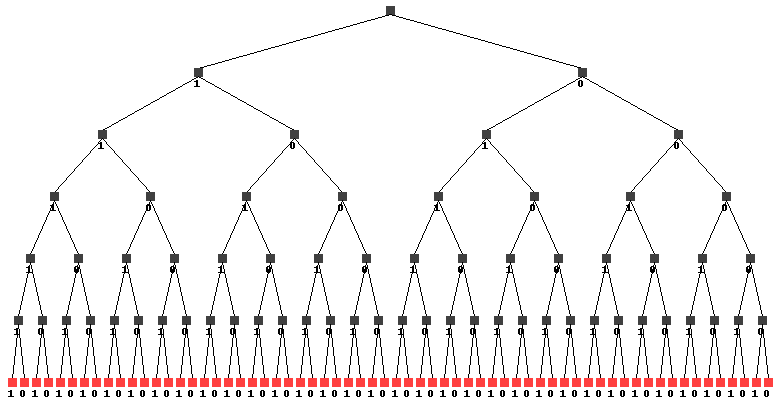

In [13]:
from PIL import Image, ImageDraw, ImageFont
def func1(dr, ini, pos, x, pr, lab):
    fn = ImageFont.load_default()
    y = pos * 62 + 10
    if pr:
        dr.line((*pr, x, y - 4), 'black')
    dr.rectangle((x - 4, y - 4, x + 4, y + 4),
                 f'#{"ff"if pos==6 else "40"}4040')
    dr.text((x - 4, y + 6), f'{lab}', 'black', fn)
    if pos < len(ini):
        w = 3 * 64 >> pos
        ini[pos] = 1
        func1(dr, ini, pos + 1, x - w, (x, y + 4), '1')
        ini[pos] = 0
        func1(dr, ini, pos + 1, x + w, (x, y + 4), '0')
        ini[pos] = -1
im = Image.new('RGB', (780, 408), (255, 255, 255))
dr = ImageDraw.Draw(im)
func1(dr, [-1] * 6, 0, 390, None, ' ')
im

In [14]:
from pulp import LpProblem, LpMaximize, lpDot, value
from ortoolpy import addvars
def knapsack(ini):
    m = LpProblem(sense=LpMaximize)  # 数理モデル
    x = addvars(6, upBound=1)  # 変数
    m += lpDot([22,24,26,28,29,30], x)  # 目的関数
    m += lpDot([10,11,12,13,14,15], x) <= 48  # 制約条件
    for i, v in zip(ini, x):
        if i >= 0:
            m += v == i
    m.solve()  # 求解
    return value(m.objective) if m.status == 1 else 0

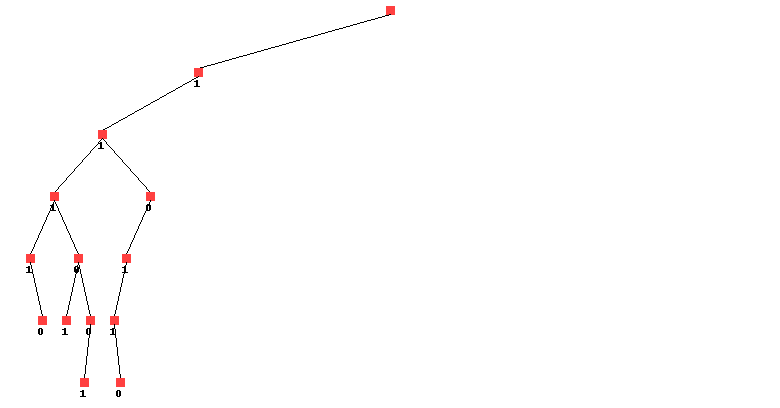

In [15]:
def func2(dr, ini, pos, x, pr, lab, zantei):
    fn = ImageFont.load_default()
    r = knapsack(ini)
    if r < zantei[0] - 1e-4:
        return
    y = pos * 62 + 10
    if pr:
        dr.line((*pr, x, y - 4), 'black')
    dr.rectangle((x - 4, y - 4, x + 4, y + 4), f'#ff4040')
    dr.text((x - 4, y + 6), f'{lab}', 'black', fn)
    if pos < len(ini):
        w = 3 * 64 >> pos
        ini[pos] = 1
        func2(dr, ini, pos+1, x-w, (x, y+4), '1', zantei)
        ini[pos] = 0
        func2(dr, ini, pos+1, x+w, (x, y+4), '0', zantei)
        ini[pos] = -1
    else:
        if zantei[0] < r:
            zantei[0] = r
im = Image.new('RGB', (780, 408), (255, 255, 255))
dr = ImageDraw.Draw(im)
func2(dr, [-1] * 6, 0, 390, None, ' ', [102])
im

In [16]:
print(f'{knapsack([0, -1, -1, -1, -1, -1]):.2f}')

102.86


### A.9 局所探索法

In [17]:
def LocalSearch(w, p, c):
    """
    ナップサック問題の局所探索法
        挿入近傍と交換近傍
    入力
        w: 大きさのリスト
        p: 価値のリスト
        c: ナップサックの大きさ
    出力
        最適値(価値)
    """
    # 残容量、解、未選択リスト
    r, a, b = c, [], [(p0, w0) for p0, w0 in zip(p, w)]
    while True:
        # 挿入近傍
        for p0, w0 in b:
            if w0 <= r:
                r -= w0
                a += [(p0, w0)]
                b.remove((p0, w0))
                break
        else:
            # 交換近傍
            for i in range(len(a)):
                pa, wa = a[i]
                for j in range(len(b)):
                    pb, wb = b[j]
                    if wb <= r + wa and pb > pa:
                        r -= wb - wa
                        a += [(pb, wb)]
                        a.remove((pa, wa))
                        b += [(pa, wa)]
                        b.remove((pb, wb))
                        break
                else: continue
                break
            else: break
    return sum(p0 for p0, w0 in a)

In [18]:
LocalSearch((10, 11, 12), (1, 2, 4), 22)

5